In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# LOADING AND CREATING DATASETS

# reading data files (first 10 input dimensions)
# input = pd.read_csv('0424_data/spectral_embedding.csv', usecols=['evec 1', 'evec 2', 'evec 3', 'evec 4', 'evec 5', 'evec 6', 'evec 7', 'evec 8', 'evec 9', 'evec 10'])
# output = pd.read_csv('0424_data/waveform.csv')            # 60 dimensions
input = pd.read_csv('0520_data/principal_component.csv', header=None)
# input = input.iloc[:, :10]
output = pd.read_csv('0520_data/waveform.csv', header=None)

# turning into (pytorch) tensor variables
input_tensor = torch.tensor(input.values, dtype=torch.float32)
output_tensor = torch.tensor(output.values, dtype=torch.float32)

# splitting the data (will be same each time as random_state is set)
input_train, input_test, output_train, output_test = train_test_split(input_tensor, output_tensor, test_size=0.2, random_state=42)
input_val, input_final_test, output_val, output_final_test = train_test_split(input_test, output_test, test_size=0.5, random_state=42)

# creating dataset and dataloader (in pytorch)
train_dataset = TensorDataset(input_train, output_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(input_val, output_val)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(input_final_test, output_final_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [67]:
# DECODER

# feed forward NN model taking 10 dimensional spectral embedding into 60 dimensional time signal
class Decoder(nn.Module):
    def __init__(self, in_dim=15, out_dim=72):      # constructor
        super(Decoder, self).__init__()             # parent class initialization

        layers = []

        # FUNNEL NEURAL NETWORK
        i = in_dim
        while i < out_dim:
            next_dim = min(i+10, out_dim)            # grow specified dimensions at a time, capped at output dimensions
            layers.append(nn.Linear(i, next_dim))
            if next_dim < out_dim:                  # activation function only activated BETWEEN layers
                layers.append(nn.ReLU())
            i = next_dim
        
        next_dim = min(i, out_dim)

        # WIDE NEURAL NETWORK
        layers.append(nn.Linear(out_dim, out_dim))
        layers.append(nn.ReLU())
        
        for i in range(2):
            layers.append(nn.Linear(out_dim,out_dim))
            layers.append(nn.ReLU())
       
        layers.append(nn.Linear(out_dim, out_dim))        

        self.net = nn.Sequential(*layers)
    
    # takes an input x and runs NN on it
    def forward(self, x):
        return self.net(x)

In [68]:
# initializing decodero bject
decoder = Decoder()

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


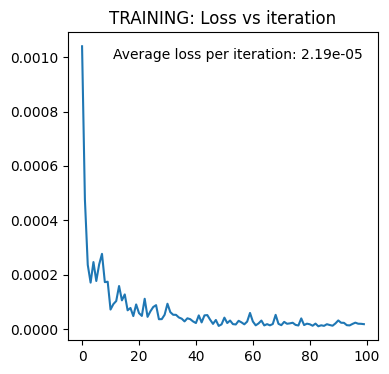

In [69]:
# TRAINING DECODER
    
optimizer = optim.Adam(decoder.parameters(), lr=1e-3)   # initializing the optimizer
criterion = nn.MSELoss()                                # using mean squared error loss function

iterations = 100

num_iterations = np.arange(iterations)
loss_array = np.zeros(iterations)


# training loop
for epoch in range(iterations):                 # training for this many epochs
    decoder.train()                             # model is in training mode
    epoch_loss = 0
    for batch_x, batch_y in train_dataloader:   # looping through training batches
        optimizer.zero_grad()                   # resetting gradients to zero
        output = decoder(batch_x)               # feeding x input into NN -> generates predicted output
        loss = criterion(output, batch_y)       # compute MSE between the prediction and the real output
        loss_array[epoch] = loss
        loss.backward()                         # use backpropagation to compute gradients
        optimizer.step()                        # update model parameters
        epoch_loss += loss.item()               # acumulate loss for monitoring

    if (epoch % 10 == 0):
        print (f"Epoch: {epoch}")

loss_per_iteration = epoch_loss
loss_per_iteration /= len(train_dataloader)

plt.figure(figsize=(4,4))
plt.plot(num_iterations,loss_array)
plt.title("TRAINING: Loss vs iteration")
plt.text(0.95, 0.95, f"Average loss per iteration: {loss_per_iteration:.2e}",
         transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=10)
plt.show()

In [70]:
# TO SAVE THIS DECODER
torch.save(decoder, 'decoders_0520/6funnel4wide_15dim.pt')

In [60]:
# TO LOAD SPECIFIC DECODER
torch.load('decoders_0520/6funnel4wide.pt', weights_only=False)

Decoder(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=70, bias=True)
    (11): ReLU()
    (12): Linear(in_features=70, out_features=72, bias=True)
    (13): Linear(in_features=72, out_features=72, bias=True)
    (14): ReLU()
    (15): Linear(in_features=72, out_features=72, bias=True)
    (16): ReLU()
    (17): Linear(in_features=72, out_features=72, bias=True)
    (18): ReLU()
    (19): Linear(in_features=72, out_features=72, bias=True)
  )
)

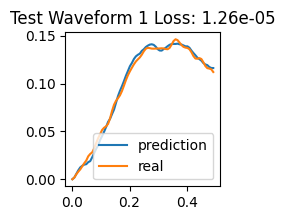

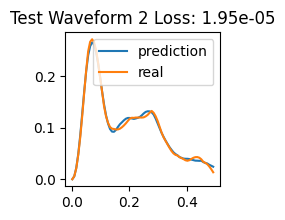

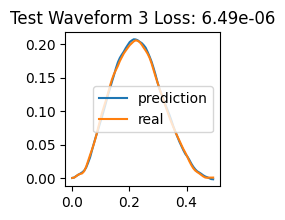

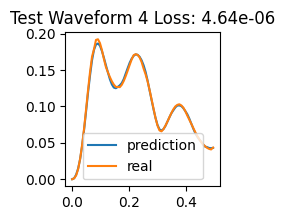

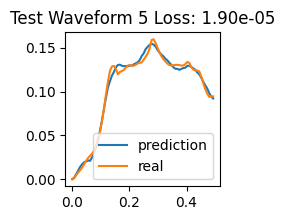

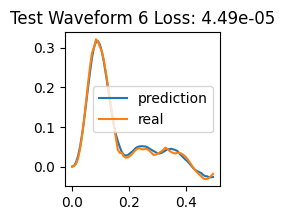

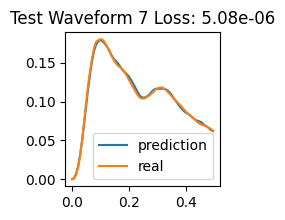

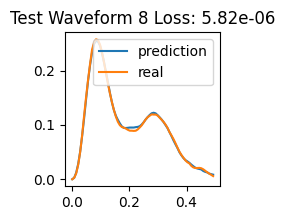

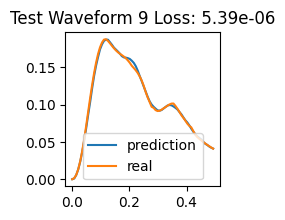

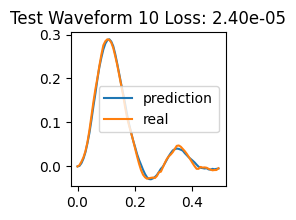

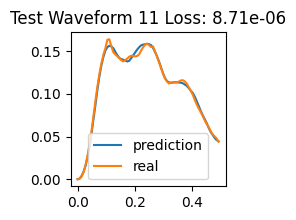

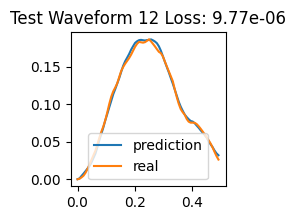

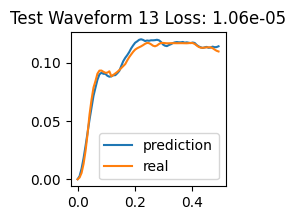

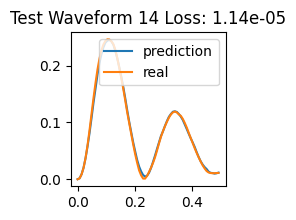

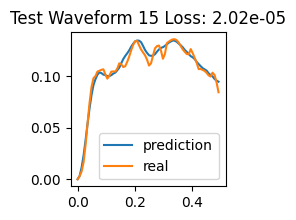

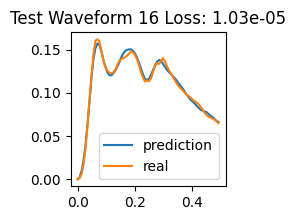

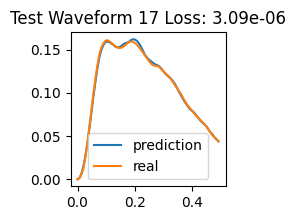

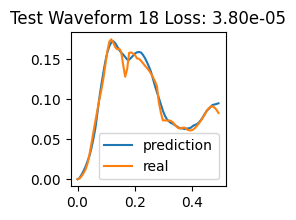

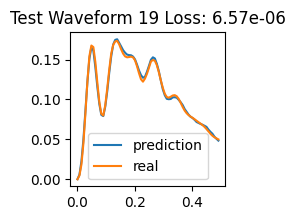

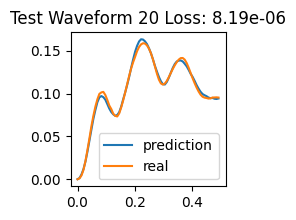

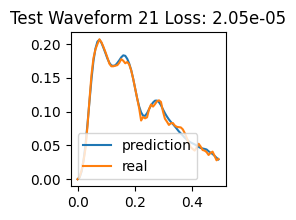

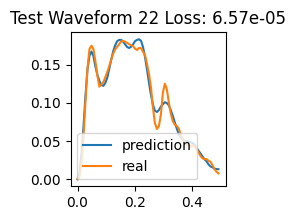

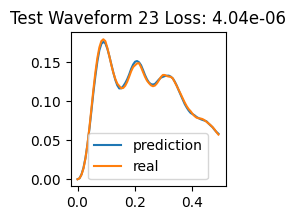

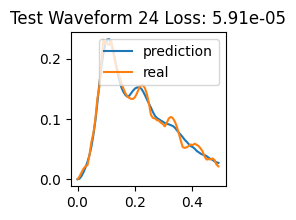

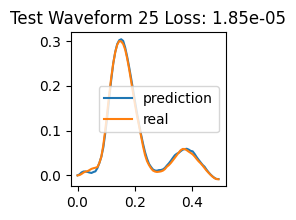

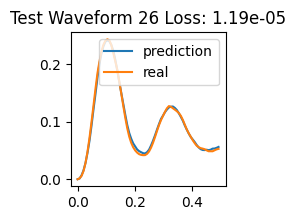

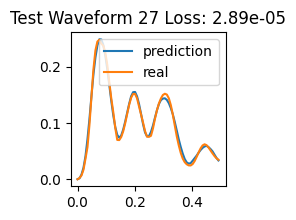

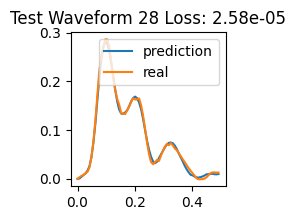

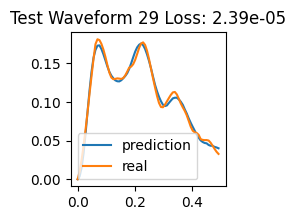

In [72]:
# USING DECODER
decoder.eval()

#time = np.arange(0,0.5,1/120)
time = np.arange(0,0.5,1/144)


for i in range(1, 30):
    with torch.no_grad():
        #input = input_train[i].unsqueeze(0)
        #output = output_train
        input = input_test[i].unsqueeze(0)
        output = output_test
        prediction = decoder(input)
        loss = criterion(prediction, output[i].unsqueeze(0))
        plt.figure(figsize=(2,2))
        plt.plot(time, prediction.flatten(), label='prediction')
        plt.plot(time, output[i], label='real')
        plt.legend()
        #plt.title(f"Train Waveform {i} Loss: {loss.item():.2e}")
        plt.title(f"Test Waveform {i} Loss: {loss.item():.2e}")
        plt.show()


# for i in range(10):
#     input = torch.zeros(10)
#     input[i] = 1

#     with torch.no_grad():
#         #input = input.unsqueeze(0)
#         prediction = decoder(input)
#         plt.figure(figsize=(2,2))
#         plt.plot(time, prediction.flatten(), label='prediction')
#         plt.show()